##**Aimonk Multilabel Classification**

--------

###**Problem Statement:**

This project addresses a multi-label image classification task where each image may contain multiple attributes. The objective is to fine-tune a pretrained deep learning model to accurately predict the presence or absence of four attributes while handling missing labels and class imbalance.

----

##**Dataset Description:**

The dataset consists of 974 dress images along with a label file containing four attribute annotations per image. Each attribute is marked as 1 (present), 0 (absent), or NA (missing information), requiring masked loss computation to ensure effective learning from partially labeled samples.

--------------------

In [3]:
#Step 1 — Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Set Paths

data_dir = "/content/drive/MyDrive/AIMONK/"
labels_path = data_dir + "labels.txt"
images_dir = data_dir + "images/"

In [5]:
#Confirm Files Exist

import os

print("Labels exists:", os.path.exists(labels_path))
print("Images folder exists:", os.path.exists(images_dir))
print("Number of images:", len(os.listdir(images_dir)))

Labels exists: True
Images folder exists: True
Number of images: 972


In [6]:
# Inspect labels.txt - Print First 25 Lines

with open(labels_path, 'r') as f:
    for _ in range(25):
        print(f.readline().strip())

image_0.jpg 1 NA 0 1
image_1.jpg NA 0 0 0
image_2.jpg 1 1 0 0
image_3.jpg 1 1 0 0
image_4.jpg 1 1 0 0
image_5.jpg NA 0 1 NA
image_6.jpg 1 1 0 0
image_7.jpg 1 1 1 0
image_8.jpg 1 1 1 0
image_9.jpg 1 NA 1 0
image_10.jpg 1 1 1 0
image_11.jpg 1 1 1 0
image_12.jpg 1 0 0 0
image_13.jpg 1 1 1 0
image_14.jpg 1 NA 0 0
image_15.jpg 0 0 0 0
image_16.jpg 1 1 0 0
image_17.jpg 1 1 0 0
image_18.jpg NA 1 1 NA
image_19.jpg 1 1 1 0
image_20.jpg 1 1 0 0
image_21.jpg 1 1 0 0
image_22.jpg 1 1 0 0
image_23.jpg 1 1 1 0
image_24.jpg 1 1 0 1


In [7]:
# Properly Convert to DataFrame

import pandas as pd
import numpy as np

df = pd.read_csv(labels_path, sep=" ", header=None)

df.columns = ["image_name", "attr1", "attr2", "attr3", "attr4"]

df.head()

,image_name,attr1,attr2,attr3,attr4
0,image_0.jpg,1.0,NaN,0.0,1.0
1,image_1.jpg,NaN,0.0,0.0,0.0
2,image_2.jpg,1.0,1.0,0.0,0.0
3,image_3.jpg,1.0,1.0,0.0,0.0
4,image_4.jpg,1.0,1.0,0.0,0.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_name  975 non-null    object 
 1   attr1       895 non-null    float64
 2   attr2       884 non-null    float64
 3   attr3       882 non-null    float64
 4   attr4       881 non-null    float64
dtypes: float64(4), object(1)
memory usage: 38.2+ KB


In [9]:
df.describe()

,attr1,attr2,attr3,attr4
count,895.000000,884.000000,882.000000,881.000000
mean,0.881564,0.806561,0.528345,0.077185
std,0.323304,0.395218,0.499479,0.267036
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [10]:
df.shape

(975, 5)

In [11]:
df.isnull().sum()

,0
image_name,0
attr1,80
attr2,91
attr3,93
attr4,94


In [12]:
# Replace BOTH "NA" and NaN with -1

df.replace("NA", -1, inplace=True)

# Replace actual NaN with -1
df.fillna(-1, inplace=True)

# Convert label columns to numeric
for col in ["attr1", "attr2", "attr3", "attr4"]:
    df[col] = pd.to_numeric(df[col])

df.isnull().sum()

,0
image_name,0
attr1,0
attr2,0
attr3,0
attr4,0


In [ ]:
df.head()

In [13]:
#Verify Label Distribution
for col in ["attr1", "attr2", "attr3", "attr4"]:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())


attr1 value counts:
attr1
 1.0    789
 0.0    106
-1.0     80
Name: count, dtype: int64

attr2 value counts:
attr2
 1.0    713
 0.0    171
-1.0     91
Name: count, dtype: int64

attr3 value counts:
attr3
 1.0    466
 0.0    416
-1.0     93
Name: count, dtype: int64

attr4 value counts:
attr4
 0.0    813
-1.0     94
 1.0     68
Name: count, dtype: int64


### **Handling Class Imbalance**

The dataset is imbalanced across attributes, especially for `attr4`, which contains significantly fewer positive samples.

To address this, positive class weights are computed using:

####**pos_weight = (number of negative samples) / (number of positive samples)**


These weights are incorporated into the loss function to penalize rare positive classes more strongly during training.

---------------------

In [14]:
pos_weights = []

for col in ["attr1", "attr2", "attr3", "attr4"]:
    valid = df[df[col] != -1][col]

    positives = (valid == 1).sum()
    negatives = (valid == 0).sum()

    weight = negatives / positives
    pos_weights.append(weight)

    print(f"{col} -> positives: {positives}, negatives: {negatives}, pos_weight: {weight:.2f}\n")

pos_weights

attr1 -> positives: 789, negatives: 106, pos_weight: 0.13

attr2 -> positives: 713, negatives: 171, pos_weight: 0.24

attr3 -> positives: 466, negatives: 416, pos_weight: 0.89

attr4 -> positives: 68, negatives: 813, pos_weight: 11.96



[np.float64(0.13434727503168567),
 np.float64(0.23983169705469845),
 np.float64(0.8927038626609443),
 np.float64(11.955882352941176)]

In [40]:
#Missing images
missing = []

for img in df["image_name"]:
    if not os.path.exists(images_dir + img):
        missing.append(img)

print("Missing images count:", len(missing))
print("\nSome missing images:", missing[:10])

Missing images count: 0

Some missing images: []


In [41]:
#Remove misisng images

df = df[df["image_name"].apply(lambda x: os.path.exists(images_dir + x))]

print("Cleaned dataset size:", len(df))

Cleaned dataset size: 972


In [42]:
#Train / Validation Split

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))

Train size: 777
Val size: 195


In [43]:
#Image Preprocessing Function

import tensorflow as tf

IMG_SIZE = 224

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

In [44]:
#Create TF Dataset

def create_dataset(dataframe, batch_size=32):

    image_paths = dataframe["image_name"].apply(lambda x: images_dir + x).values
    labels = dataframe[["attr1", "attr2", "attr3", "attr4"]].values.astype("float32")

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def load_data(path, label):
        image = preprocess_image(path)
        return image, label

    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [45]:
train_dataset = create_dataset(train_df, batch_size=32)
val_dataset = create_dataset(val_df, batch_size=32)

### **Masked Weighted Binary Cross-Entropy Loss**

Since some attribute labels are marked as `NA`, they are converted to `-1` and ignored during loss computation using a masking mechanism.  

The custom loss function combines masking (to skip missing labels) and class weighting (to handle imbalance) while training on logits directly.

---------------

In [46]:
import tensorflow as tf

# Convert pos_weights to tensor
pos_weights_tensor = tf.constant(pos_weights, dtype=tf.float32)

def masked_weighted_bce(y_true, y_pred):
    """
    y_true shape: (batch, 4)
    y_pred shape: (batch, 4)  -> logits
    """

    # Create mask: ignore -1 labels
    mask = tf.not_equal(y_true, -1.0)
    mask = tf.cast(mask, tf.float32)

    # Replace -1 with 0 so BCE can compute safely
    y_true_clean = tf.where(tf.equal(y_true, -1.0), 0.0, y_true)

    # Standard BCE with logits
    bce = tf.nn.weighted_cross_entropy_with_logits(
        labels=y_true_clean,
        logits=y_pred,
        pos_weight=pos_weights_tensor
    )

    # Apply mask
    bce = bce * mask

    # Normalize by number of valid labels
    return tf.reduce_sum(bce) / tf.reduce_sum(mask)

In [47]:
#Build Model (ResNet50 Fine-Tuning)

from tensorflow.keras import layers, models

base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # freeze backbone first

x = layers.GlobalAveragePooling2D()(base_model.output)
outputs = layers.Dense(4)(x)  # 4 logits, NO sigmoid

model = models.Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=masked_weighted_bce
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [48]:
#Train

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 676ms/step - loss: 0.7196 - val_loss: 0.6831
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.6892 - val_loss: 0.6869
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.6764 - val_loss: 0.6892
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.6648 - val_loss: 0.6919
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.6543 - val_loss: 0.6949


In [53]:
#Save Model

model.save("/content/drive/MyDrive/AIMONK/aimonk_multilabel_model.h5")

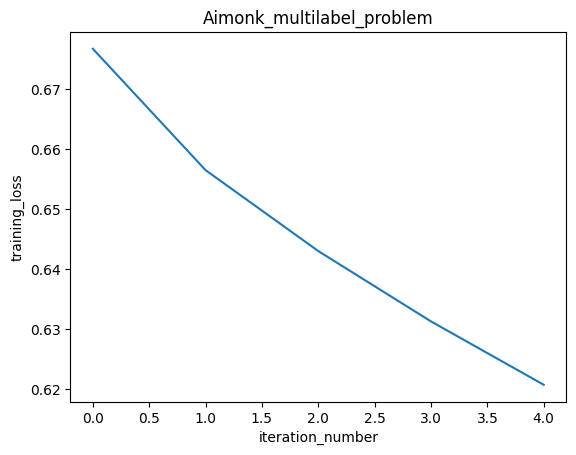

In [55]:
#Plot Training Loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

plt.xlabel("iteration_number")
plt.ylabel("training_loss")
plt.title("Aimonk_multilabel_problem")

plt.savefig("/content/drive/MyDrive/AIMONK/loss_curve.png")
plt.show()

###**INFERENCE**

In [52]:
import numpy as np

# Load saved model
model = tf.keras.models.load_model(
    "aimonk_multilabel_model.h5",
    custom_objects={"masked_weighted_bce": masked_weighted_bce}
)

attribute_names = ["attr1", "attr2", "attr3", "attr4"]

def predict_image(image_path):
    image = preprocess_image(image_path)
    image = tf.expand_dims(image, axis=0)

    logits = model.predict(image)

    # Apply sigmoid during inference to convert logits to probabilities.
    # Sigmoid is not included in the model because training uses from_logits=True.

    probs = tf.sigmoid(logits).numpy()[0]

    predictions = []

    for i, prob in enumerate(probs):
        if prob > 0.5:
            predictions.append(attribute_names[i])

    print("\nPredicted Attributes:", predictions)
    print("Probabilities:", probs)

# Example usage
sample_path = images_dir + df.iloc[0]["image_name"]
predict_image(sample_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

Predicted Attributes: ['attr2', 'attr3', 'attr4']
Probabilities: [0.43276697 0.75874555 0.6712045  0.8168756 ]


### **Conclusion**

A pretrained ResNet50 model was fine-tuned for multi-label classification while handling missing labels and class imbalance.  

The approach demonstrates robust data handling and practical deep learning engineering for real-world imperfect datasets.

-----------------